# Simple Visualizations

Let's now use the tidied data to create some simple figures over the aggregated data. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [5]:
# Load the dataset
df = pd.read_csv("tidied_nhl.csv")

# Comparing Shot Types and Goal Conversion for a Selected Season

We will use a stacked bar chart to show the distribution of different shot types (e.g., wrist shot, slapshot) across all teams for a chosen season (in our case, it is the 2016-17 season). Overlaying goals on top of shots in the same chart will allow us to easily compare the effectiveness of the different shot types.

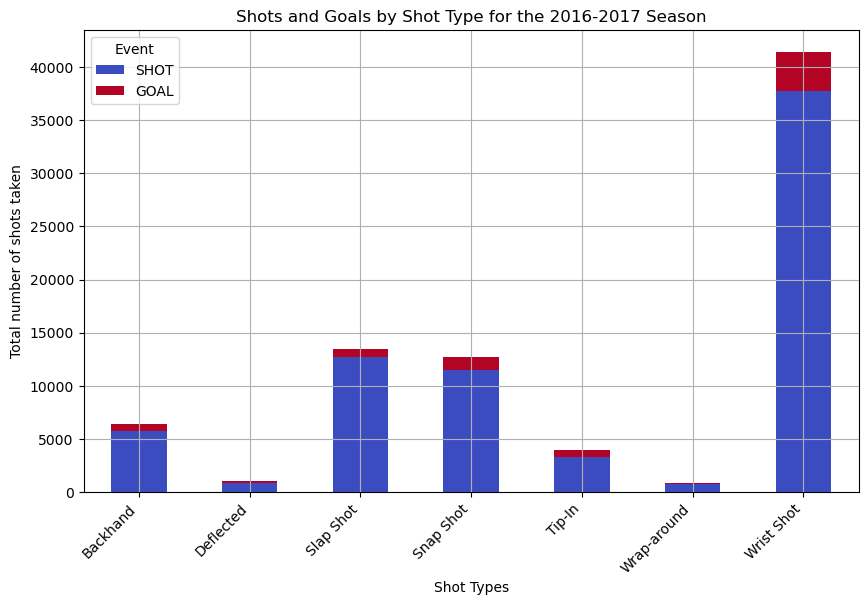

In [6]:
# Select a season
season = '2016-2017'

# Select only the rows of the chosen season
season_df = df[df['Season'] == season]

shot_data = season_df.groupby(['ShotType', 'Event']).size().unstack(fill_value=0)

# Plot the stacked bar chart
ax = shot_data[['SHOT', 'GOAL']].plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(10, 6))

plt.title(f'Shots and Goals by Shot Type for the {season} Season')
plt.xlabel('Shot Types')
plt.ylabel('Total number of shots taken')
plt.legend(title='Event')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

# Relationship Between Shot Distance and Goal Probability From the 2018-19 to 2020-21 Seasons

We will create line plots with shot distance on the x-axis and the chance of a goal (goal probability) on the y-axis for each season from 2018-19 to 2020-21. We will do one figure per season and one figure of all 3 seasons together in order to view the differences between the seasons more easily.

In [7]:
# Calculates the distance between a shot/goal and the net, rounded to the nearest number
# the column 'distance_to_goal' is added to the df
def distance(df: pd.DataFrame) -> pd.DataFrame:
    right_goal = [89, 0]
    left_goal = [-89, 0]

    distance_to_goal = np.zeros(df.shape[0])
    for i, row in df.iterrows():
    
        if row['RinkSide'] == 'right':
            distance_to_goal[i] = np.sqrt((row['XCoord'] - left_goal[0])**2 + (row['YCoord'] - left_goal[1])**2).round()
        
        elif row['RinkSide'] == 'left':
            distance_to_goal[i] = np.sqrt((row['XCoord'] - right_goal[0])**2 + (row['YCoord'] - right_goal[1])**2).round()
    
        else:
            distance_to_goal[i] = None  # some games didn't have the information for which side the team was defending

    # add the column with its values
    df['distance_to_goal'] = distance_to_goal
    return df


In [8]:
# Creates multiple graphs (one for each desired season) with one line plot
def plot_shot_goal_ratio(seasons: [str]):
    for i, season in enumerate(seasons):
        s = season.split("-")[0]  # assuming that the input will always be the format "yyyy-yyyy"
        season_df = df[df['GameID'].astype(str).str.startswith(s)]
        shot_season_df = season_df[season_df['GameID'].astype(str).str.startswith(s)]
        shot_season_df.reset_index(inplace=True)
        shot_season_df = distance(shot_season_df)
        result_df = shot_season_df.groupby('distance_to_goal').agg(
            shots=('Event', lambda x: (x == 'SHOT').sum()),
            goals=('Event', lambda x: (x == 'GOAL').sum())
        )
        # Calculate shot_goal_ratio
        result_df['shot_goal_ratio'] = result_df['goals'] / (result_df['shots'] + result_df['goals'])

        # Reset the index to get a clean DataFrame
        result_df.reset_index(inplace=True)

        # Plot the line graph
        plt.figure(figsize=(10, 6))
        plt.plot(result_df['distance_to_goal'], result_df['shot_goal_ratio'], label=s)
        plt.title(f'Shot-to-Goal Ratio vs. Distance to Goal for {season} season')
        plt.xlabel('Distance to Goal (in feet)')
        plt.ylabel('Shot-to-Goal Ratio')
        plt.grid(True)
        plt.show()


In [9]:
# Creates single graph with one line plot figure for each the desired season
def plot_shot_goal_ratio_full(seasons: [str]):
    # Graph for all seasons together
    plt.figure(figsize=(10, 6))

    # Create a list to store individual line plots
    line_plots = []

    for season in seasons:
        s = season.split("-")[0]  # assuming that the input will always be the format "yyyy-yyyy"
        season_df = df[df['GameID'].astype(str).str.startswith(s)]
        shot_season_df = season_df[season_df['GameID'].astype(str).str.startswith(s)]
        shot_season_df.reset_index(inplace=True)
        shot_season_df = distance(shot_season_df)
        result_df = shot_season_df.groupby('distance_to_goal').agg(
            shots=('Event', lambda x: (x == 'SHOT').sum()),
            goals=('Event', lambda x: (x == 'GOAL').sum())
        )
        # Calculate shot_goal_ratio
        result_df['shot_goal_ratio'] = result_df['goals'] / (result_df['shots'] + result_df['goals'])
    
        # Reset the index to get a clean DataFrame
        result_df.reset_index(inplace=True)
    
        # Create individual line plots for each season
        line_plot, = plt.plot(result_df['distance_to_goal'], result_df['shot_goal_ratio'], label=f'Season {season}')
        line_plots.append(line_plot)

    # Create a legend for the final combined graph
    plt.legend(handles=line_plots, loc='upper right')
    
    plt.title('Shot-to-Goal Ratio vs. Distance to Goal from the 2018-19 to 2020-21 seasons')
    plt.xlabel('Distance to Goal (in feet)')
    plt.ylabel('Shot-to-Goal Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()



In [10]:
# Select list of seasons to plot
seasons = ['2018-2019', '2019-2020', '2020-2021']

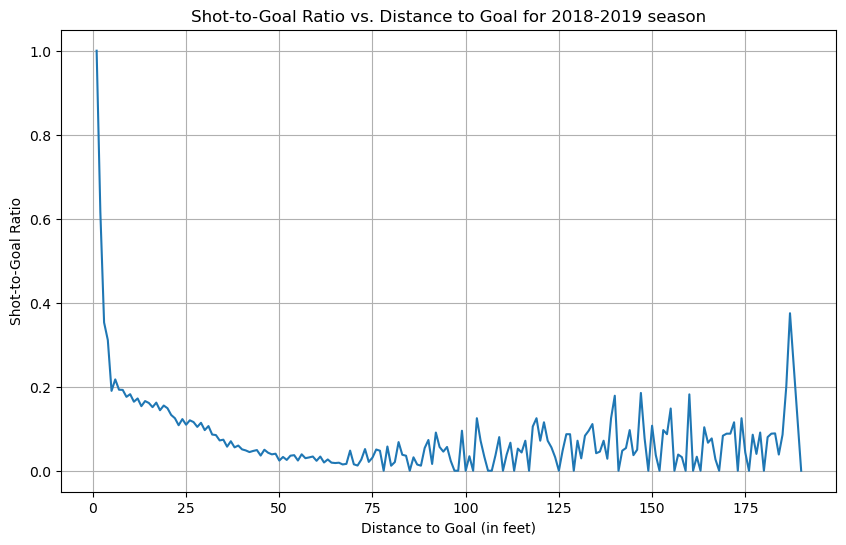

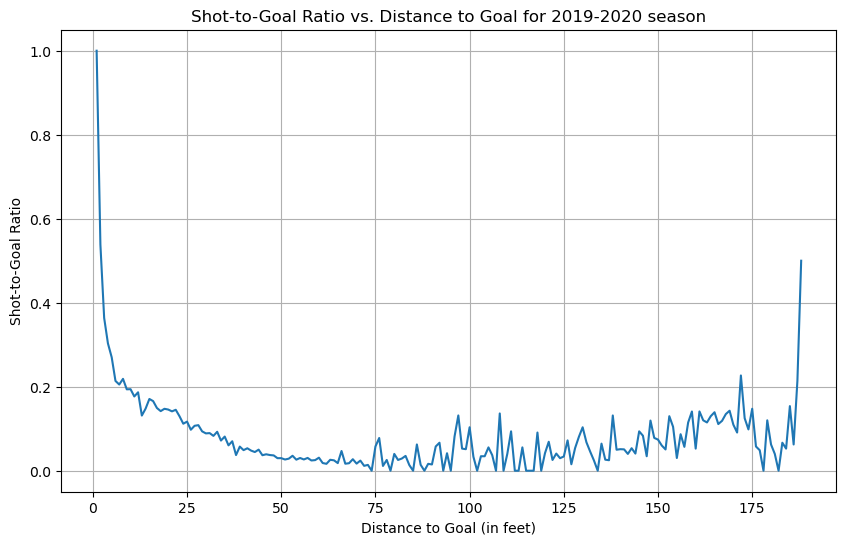

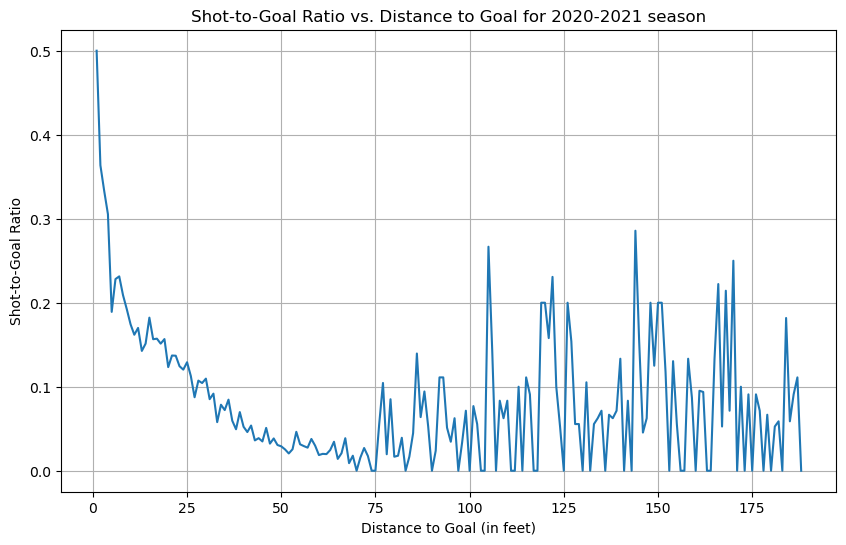

In [11]:
# plot the individual graphs
plot_shot_goal_ratio(seasons)

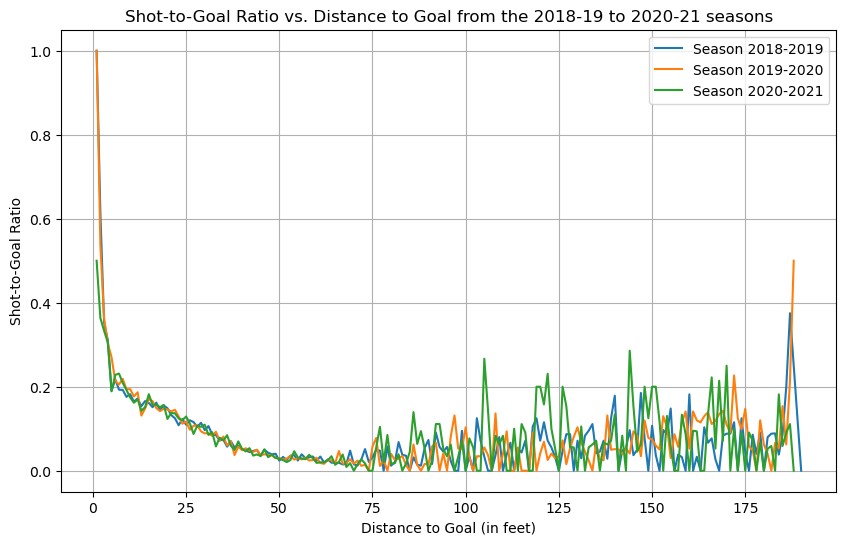

In [12]:
# plot the single graph with multiple line plots
plot_shot_goal_ratio_full(seasons)

# Goal Percentage by Shot Type and Distance for the 2016-17 Season

We will use a heatmap where the x-axis represents shot distance from the net, the y-axis represents different shot types (e.g., wrist shot, slapshot). The color intensity in each cell represents the goal percentage (# goals / # shots) for that combination of shot type and distance. Darker colors indicate higher goal percentages, while lighter colors indicate lower goal percentages.

In [35]:
df = pd.read_csv("tidied_nhl.csv")
season = '2016-2017'

# Select only the rows of the chosen season
season_df = df[df['Season'] == season]
distance_df = distance(season_df)

# Count the occurrences of each unique value
value_counts = distance_df['distance_to_goal'].value_counts()
# print(value_counts, distance_df['distance_to_goal'].max())

bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]#the reason to set bin like this is to average the number of events
labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70']
categories = pd.cut(distance_df['distance_to_goal'], bins=bins, labels=labels, include_lowest=True)

# Create a new Series with the associated category labels
categorized_series = pd.Series(categories, name='Category')
distance_df['distance_category'] = categorized_series


# table = pd.pivot_table(distance_df, index=['distance_category', 'ShotType'],columns=['Event'], aggfunc="sum")
# table
grouped = distance_df.groupby(['distance_category', 'ShotType', 'Event']).size().unstack(fill_value=0)

# Reshape the data using pivot_table to get the desired format
result = grouped.pivot_table(index='ShotType', columns='distance_category', values=['GOAL', 'SHOT'], fill_value=0)
# print(categorized_series)
# categorized_series.value_counts()
# distance_df.head()
result

/tmp/ipykernel_23584/3939614266.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_to_goal'] = distance_to_goal
/tmp/ipykernel_23584/2547050611.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distance_df['distance_category'] = categorized_series
/tmp/ipykernel_23584/2547050611.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defau

Event              GOAL                                                   \
distance_category   0-5   5-10  10-15  15-20  20-25  25-30  30-35  35-40   
ShotType                                                                   
Backhand           32.0  308.0  192.0   55.0   21.0    8.0    4.0    5.0   
Deflected           8.0   84.0   49.0   28.0    6.0    5.0    2.0    4.0   
Slap Shot           5.0   19.0   26.0   35.0   57.0   70.0   98.0   95.0   
Snap Shot          13.0  113.0  143.0  172.0  169.0  160.0  140.0   84.0   
Tip-In             20.0  317.0  189.0  103.0   44.0   15.0    3.0    5.0   
Wrap-around        18.0   46.0    4.0    0.0    0.0    1.0    0.0    0.0   
Wrist Shot         74.0  726.0  710.0  473.0  394.0  324.0  224.0  167.0   

Event                          ...    SHOT                                  \
distance_category 40-45 45-50  ...   20-25   25-30   30-35   35-40   40-45   
ShotType                       ...                                           
Backhand            1.0   3.0  ...   554.0   346.0   247.0   172.0   109.0   
Deflected           3.0   1.0  ...    58.0    29.0    15.0     9.0     6.0   
Slap Shot          87.0  84.0  ...   256.0   475.0   746.0  1015.0  1288.0   
Snap Shot          50.0  27.0  ...  1075.0  1331.0  1400.0  1415.0  1174.0   
Tip-In              2.0   3.0  ...   224.0   103.0    33.0    11.0    11.0   
Wrap-around         0.0   0.0  ...     3.0     0.0     1.0     1.0     2.0   
Wrist Shot         96.0  77.0  ...  3287.0  3530.0  3654.0  3682.0  3388.0   

Event                                                     
distance_category   45-50   50-55   55-60   60-65  65-70  
ShotType                                                  
Backhand             73.0    45.0    39.0    10.0   18.0  
Deflected             6.0     9.0    11.0     4.0    8.0  
Slap Shot          1603.0  2393.0  2467.0  1213.0  290.0  
Snap Shot           972.0   779.0   742.0   372.0  115.0  
Tip-In                8.0    18.0    15.0    20.0   16.0  
Wrap-around           0.0     0.0     0.0     0.0    0.0  
Wrist Shot         2722.0  2448.0  2145.0  1270.0  501.0  

[7 rows x 28 columns]

In [61]:
percentage_df = result['GOAL'].div(result['SHOT']).fillna(0)
percentage_df.replace([np.inf], 1, inplace=True)
percentage_df.iloc[1, 0] = 1
# percentage_df_transposed = percentage_df.T
percentage_array = percentage_df.values.reshape(14, 7)
percentage_df, percentage_array

(distance_category       0-5      5-10     10-15     15-20     20-25     25-30  \
 ShotType                                                                        
 Backhand           0.571429  0.200651  0.120376  0.064103  0.037906  0.023121   
 Deflected          1.000000  0.344262  0.192157  0.220472  0.103448  0.172414   
 Slap Shot          0.625000  0.306452  0.250000  0.261194  0.222656  0.147368   
 Snap Shot          0.361111  0.287532  0.250438  0.219108  0.157209  0.120210   
 Tip-In             0.645161  0.289234  0.169964  0.200780  0.196429  0.145631   
 Wrap-around        0.134328  0.087954  0.050000  0.000000  0.000000  1.000000   
 Wrist Shot         0.496644  0.248120  0.205025  0.154021  0.119866  0.091785   
 
 distance_category     30-35     35-40     40-45     45-50     50-55     55-60  \
 ShotType                                                                        
 Backhand           0.016194  0.029070  0.009174  0.041096  0.000000  0.000000   
 Deflected    

In [59]:
# percentage_array
for i in range(len(percentage_array)):
    for j in range(len(percentage_array[0])):
        if percentage_array[i][j] >1:
            print([i, j])

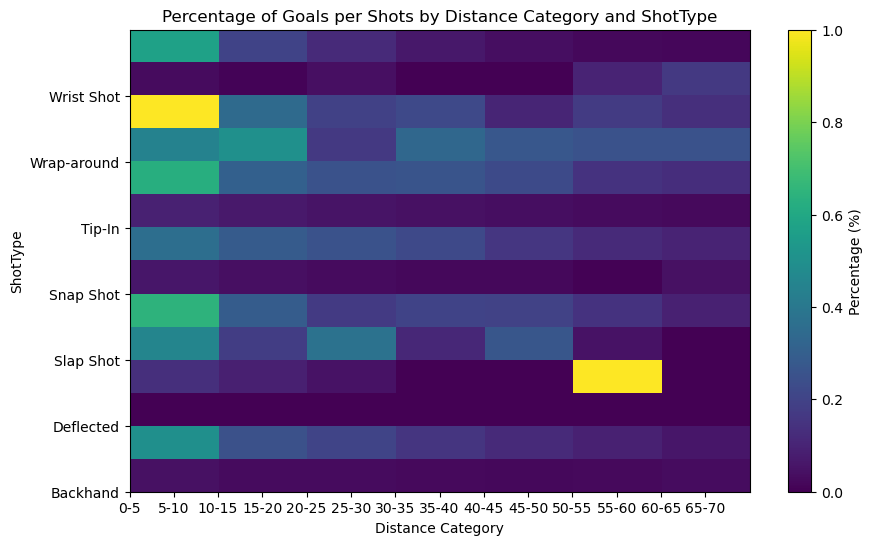

In [62]:
category_bins = ['Backhand', 'Deflected', 'Slap Shot', 'Snap Shot', 'Tip-In', 'Wrap-around', 'Wrist Shot']
labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70']

percentage_df = result['GOAL'].div(result['SHOT']).fillna(0)
percentage_df.replace([np.inf], 1, inplace=True)
percentage_df.iloc[1, 0] = 1
# percentage_df_transposed = percentage_df.T
percentage_array = percentage_df.values.reshape(14, 7)
# percentage_df, percentage_array, percentage_array.shape


plt.figure(figsize=(10, 6))
plt.imshow(percentage_array, cmap='viridis', aspect='auto', extent=[0, len(labels), 0, len(category_bins)])

# Set labels and ticks
plt.xlabel('Distance Category')
plt.ylabel('ShotType')
plt.xticks(range(len(labels)), labels)
plt.yticks(range(len(category_bins)), category_bins)
plt.colorbar(label='Percentage (%)')

# Display the plot
plt.title('Percentage of Goals per Shots by Distance Category and ShotType')
plt.show()